
# Fine-tuning a Model with the 🤗 Transformers Trainer API

This notebook is a **hands-on practice notebook** covering:
- Dataset loading (GLUE MRPC)
- Tokenization & Data Collation
- Trainer API fine-tuning
- Evaluation with 🤗 Evaluate
- Advanced training options (fp16, gradient accumulation)


## 1. Install & Import Libraries

In [1]:

!pip install -q transformers datasets evaluate accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00


In [2]:
import numpy as np
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
import evaluate

## 2. Load Dataset (GLUE MRPC)

In [3]:
raw_datasets = load_dataset("glue", "mrpc")
raw_datasets

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

mrpc/train-00000-of-00001.parquet:   0%|          | 0.00/649k [00:00<?, ?B/s]

mrpc/validation-00000-of-00001.parquet:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

mrpc/test-00000-of-00001.parquet:   0%|          | 0.00/308k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

## 3. Load Tokenizer

In [4]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## 4. Tokenization

In [5]:
def tokenize_function(example):
    return tokenizer(
        example["sentence1"],
        example["sentence2"],
        truncation=True
    )

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

## 5. Data Collator (Dynamic Padding)

In [6]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## 6. Training Arguments

In [8]:
training_args = TrainingArguments(
    output_dir="test-trainer", # Saves logging and checkpoint
    eval_strategy="epoch",
)

## 7. Load Model

## If num_labels is different from the original configuration, then the classifier weight will be initialized newly as the warning shows...

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=2
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 8. Define Trainer (Without Metrics)

In [10]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    processing_class=tokenizer, # A tokenizer for raw dataset
)

## 9. Train Model

## How to define Trainer?

In [ ]:
from torch import nn
from typing import Dict, List, Tuple, Optional, Any, Union
from transformers.trainer import Trainer
from torch import nn
import torch
import numpy as np

class BaseTrainer(Trainer):
    def __init__(self, **kwds):
        super().__init__(**kwds)

        self.loss_fn = nn.CrossEntropyLoss()

    def compute_loss(self, model, inputs, num_items_in_batch = None, return_outputs=False):
        image = inputs['image']
        label = inputs['label']
        # Forward pass
        output = model(image)
        # Compute loss
        loss = self.loss_fn(output, label)


        if return_outputs:
            return loss, output, label
        return loss

    def prediction_step( # A function that evaluates batch during validation and inference
            self,
            model: nn.Module,
            inputs: Dict[str, Union[torch.Tensor, Any]],
            prediction_loss_only: bool,
            ignore_keys: Optional[List[str]] = None,
    ) -> Tuple[Optional[torch.Tensor], Optional[torch.Tensor], Optional[torch.Tensor]]:

        model.eval()

        with torch.no_grad():
            eval_loss, pred, label = self.compute_loss(model,inputs,return_outputs = True)

        return (eval_loss,pred,label)

More.. of Training Arguments & Trainer

In [ ]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import random
import numpy as np
import torch
import transformers
from transformers import TrainingArguments
import wandb

from arguments import get_arguments

from src.dataset.get_dataset import get_dataset
from src.model.get_model import get_model
from src.trainer import BaseTrainer
from src.utils.compute_metrics import compute_metrics

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def main(args):

    device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
    print(device)
    set_seed(42)

    ## =================== Data =================== ##
    train_dataset, val_dataset, data_collator = get_dataset(args)

    ## =================== Model =================== ##
    model = get_model(args)

    ## =================== Trainer =================== ##

    wandb.init(project='2025_Torch_Session_3week', name=f'{args.save_dir}')

    training_args = TrainingArguments(
        output_dir=f"./ckpt/{args.save_dir}",
        eval_strategy='epoch',
        eval_steps=args.eval_steps,
        per_device_train_batch_size=args.per_device_train_batch_size,
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        per_device_eval_batch_size=args.per_device_eval_batch_size,
        num_train_epochs=args.num_train_epochs,
        learning_rate=args.learning_rate,
        warmup_ratio=args.warmup_ratio,
        logging_steps=10,
        metric_for_best_model="f1_score",
        save_strategy="epoch",
        save_total_limit=None,
        save_steps=args.save_steps,
        remove_unused_columns=False,
        report_to="wandb",
        dataloader_num_workers=0,
    )

    trainer = BaseTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()

if __name__=="__main__":

    args = get_arguments()
    main(args)

## DDP & Trainer

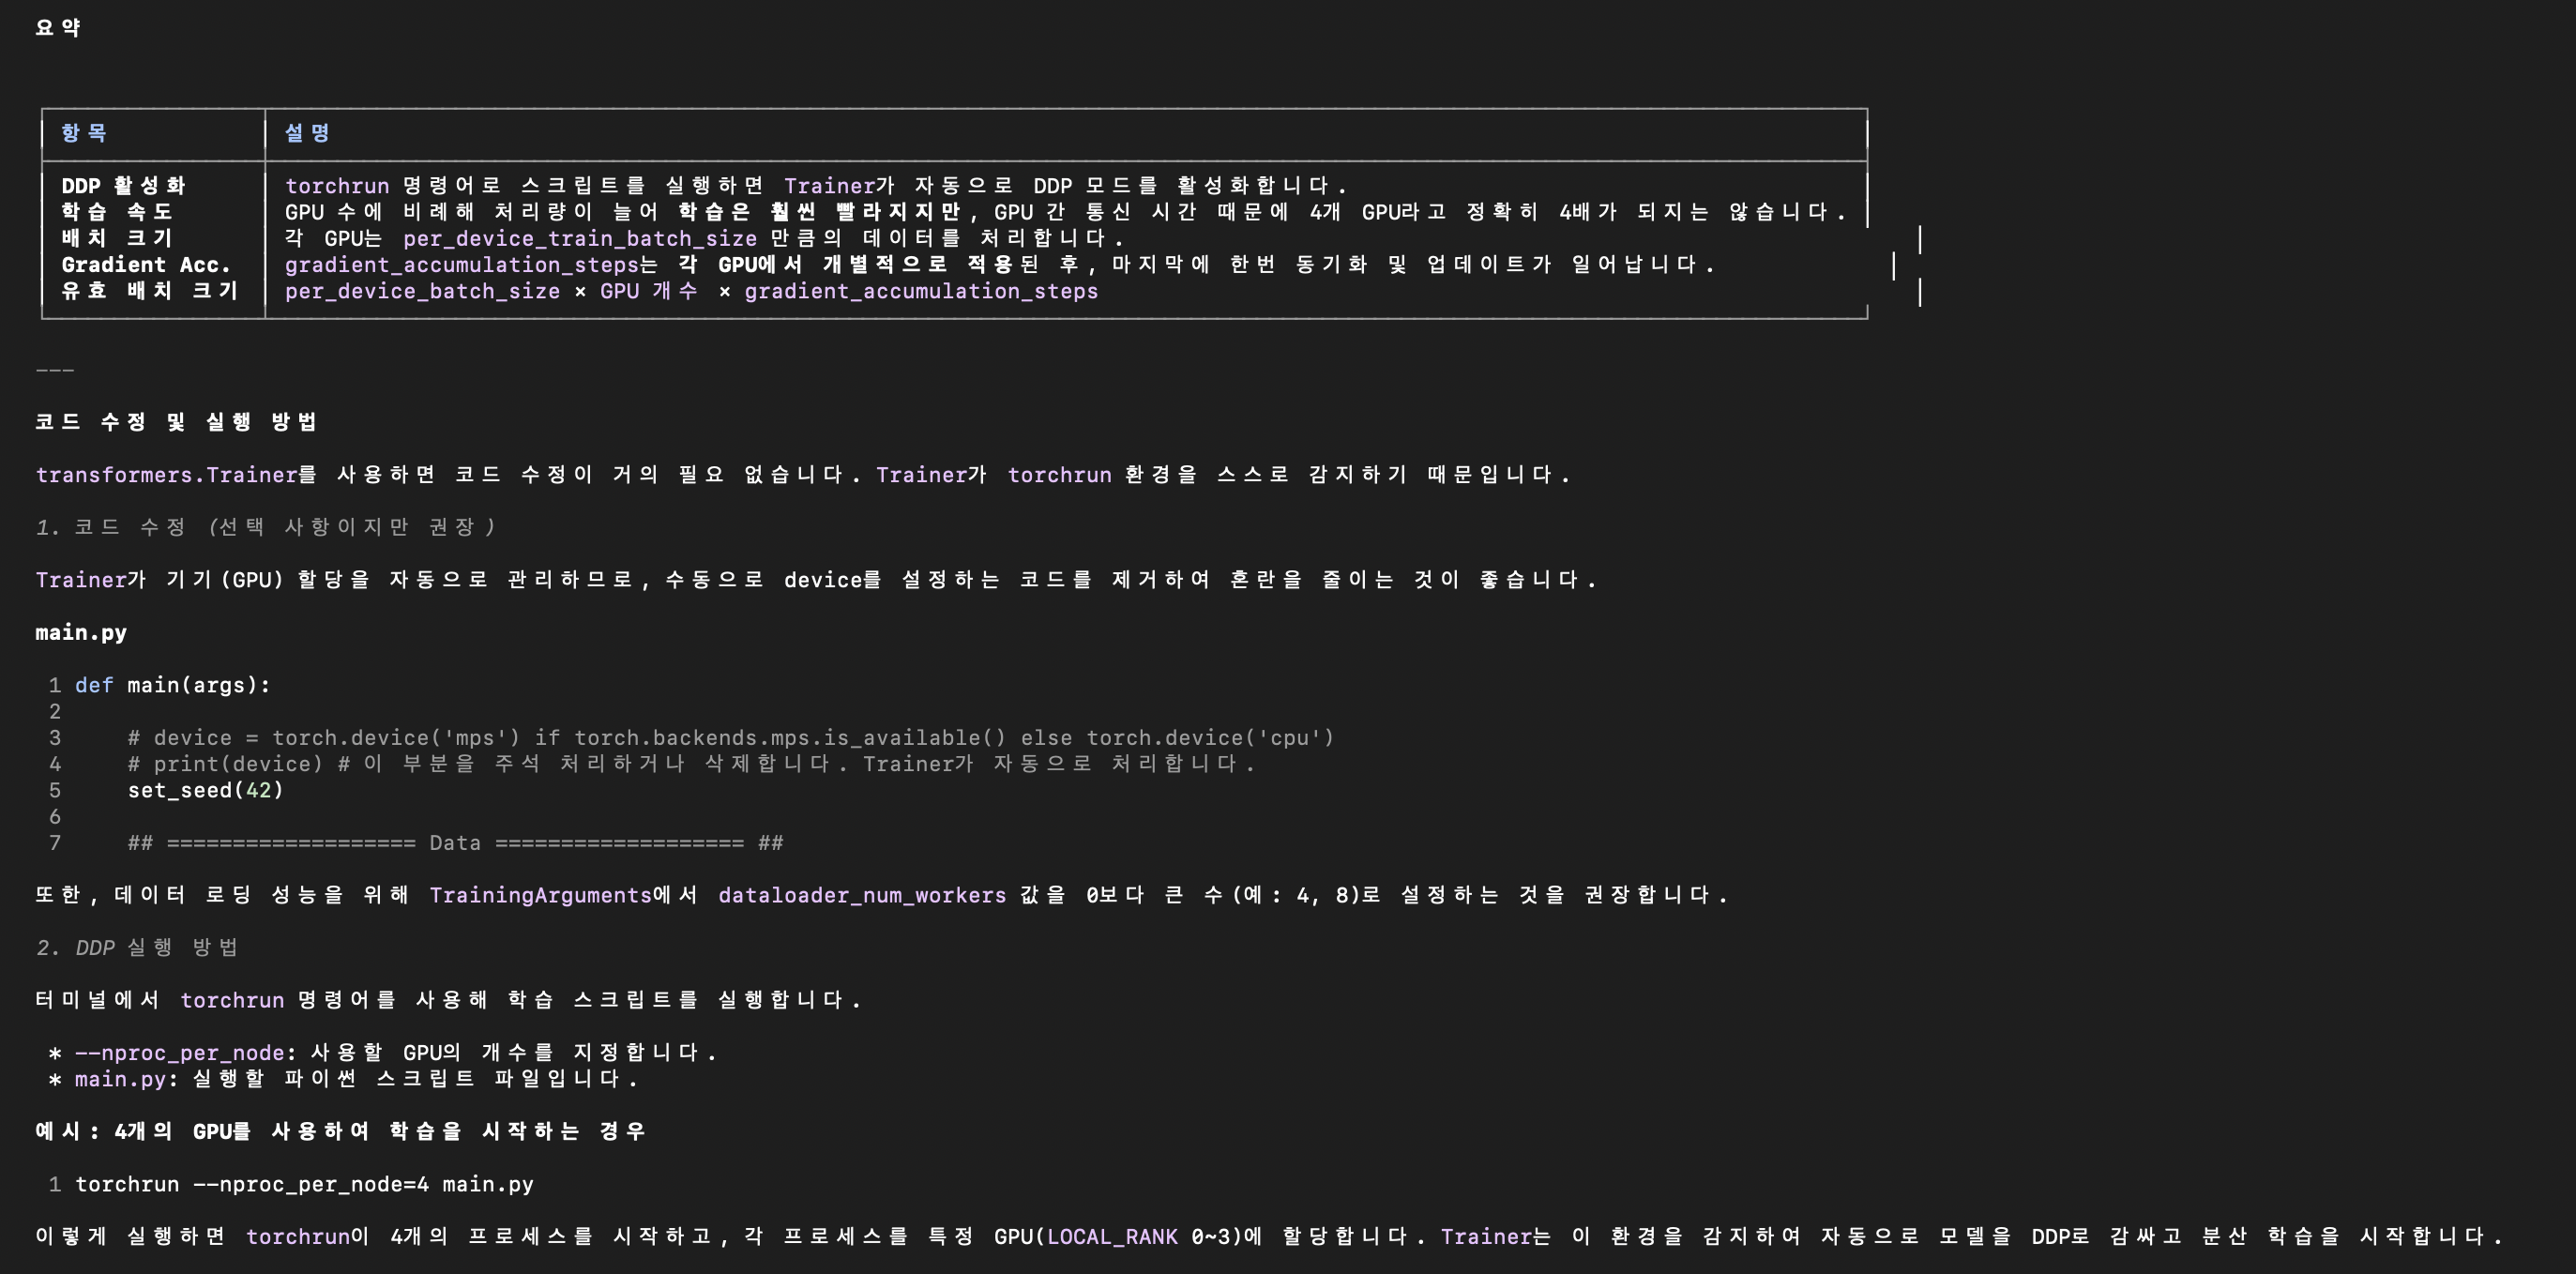

In [11]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kipyo39 (kipyo39-sungkyunkwan-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,0.533969
2,0.580100,0.427801
3,0.393200,0.604952


TrainOutput(global_step=1377, training_loss=0.42820897098893085, metrics={'train_runtime': 546.5128, 'train_samples_per_second': 20.135, 'train_steps_per_second': 2.52, 'total_flos': 405114969714960.0, 'train_loss': 0.42820897098893085, 'epoch': 3.0})

## 10. Prediction & Logits Inspection

In [12]:
predictions = trainer.predict(tokenized_datasets["validation"])
predictions.predictions.shape, predictions.label_ids.shape
# Logits & Labels

((408, 2), (408,))

## 11. Convert Logits to Class Predictions

In [13]:
preds = np.argmax(predictions.predictions, axis=-1)

## 12. Evaluate with 🤗 Evaluate

In [14]:
metric = evaluate.load("glue", "mrpc")
metric.compute(
    predictions=preds,
    references=predictions.label_ids
)

{'accuracy': 0.8455882352941176, 'f1': 0.8900523560209425}

## 13. Define compute_metrics Function

In [15]:
def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(
        predictions=predictions,
        references=labels
    )

## 14. Trainer with Evaluation Metrics

In [17]:
training_args = TrainingArguments(
    output_dir="test-trainer",
    eval_strategy="epoch",
)

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 15. Train with Metrics => Compute Metrics were given for Trainer

In [18]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.391259,0.828431,0.880952
2,0.512600,0.545151,0.843137,0.892617
3,0.267400,0.675197,0.855392,0.899830


TrainOutput(global_step=1377, training_loss=0.321738340755953, metrics={'train_runtime': 233.8661, 'train_samples_per_second': 47.053, 'train_steps_per_second': 5.888, 'total_flos': 405114969714960.0, 'train_loss': 0.321738340755953, 'epoch': 3.0})

## 16. Advanced Training Options

### Mixed Precision (fp16)

In [20]:
TrainingArguments(
    output_dir="test-trainer",
    eval_strategy="epoch",
    fp16=True,
)

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=True,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False,

### Gradient Accumulation

In [21]:
TrainingArguments(
    output_dir="test-trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
)

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=True,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False,

### Learning Rate Scheduler

In [22]:
TrainingArguments(
    output_dir="test-trainer",
    eval_strategy="epoch",
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
)

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=True,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False,

# IS Model Frozen? No Fine Tuning is default

In [23]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print("TRAIN:", name)

TRAIN: bert.embeddings.word_embeddings.weight
TRAIN: bert.embeddings.position_embeddings.weight
TRAIN: bert.embeddings.token_type_embeddings.weight
TRAIN: bert.embeddings.LayerNorm.weight
TRAIN: bert.embeddings.LayerNorm.bias
TRAIN: bert.encoder.layer.0.attention.self.query.weight
TRAIN: bert.encoder.layer.0.attention.self.query.bias
TRAIN: bert.encoder.layer.0.attention.self.key.weight
TRAIN: bert.encoder.layer.0.attention.self.key.bias
TRAIN: bert.encoder.layer.0.attention.self.value.weight
TRAIN: bert.encoder.layer.0.attention.self.value.bias
TRAIN: bert.encoder.layer.0.attention.output.dense.weight
TRAIN: bert.encoder.layer.0.attention.output.dense.bias
TRAIN: bert.encoder.layer.0.attention.output.LayerNorm.weight
TRAIN: bert.encoder.layer.0.attention.output.LayerNorm.bias
TRAIN: bert.encoder.layer.0.intermediate.dense.weight
TRAIN: bert.encoder.layer.0.intermediate.dense.bias
TRAIN: bert.encoder.layer.0.output.dense.weight
TRAIN: bert.encoder.layer.0.output.dense.bias
TRAIN: bert.

In [24]:
for param in model.base_model.embeddings.parameters():
    param.requires_grad = False

In [25]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print("TRAIN:", name)

TRAIN: bert.encoder.layer.0.attention.self.query.weight
TRAIN: bert.encoder.layer.0.attention.self.query.bias
TRAIN: bert.encoder.layer.0.attention.self.key.weight
TRAIN: bert.encoder.layer.0.attention.self.key.bias
TRAIN: bert.encoder.layer.0.attention.self.value.weight
TRAIN: bert.encoder.layer.0.attention.self.value.bias
TRAIN: bert.encoder.layer.0.attention.output.dense.weight
TRAIN: bert.encoder.layer.0.attention.output.dense.bias
TRAIN: bert.encoder.layer.0.attention.output.LayerNorm.weight
TRAIN: bert.encoder.layer.0.attention.output.LayerNorm.bias
TRAIN: bert.encoder.layer.0.intermediate.dense.weight
TRAIN: bert.encoder.layer.0.intermediate.dense.bias
TRAIN: bert.encoder.layer.0.output.dense.weight
TRAIN: bert.encoder.layer.0.output.dense.bias
TRAIN: bert.encoder.layer.0.output.LayerNorm.weight
TRAIN: bert.encoder.layer.0.output.LayerNorm.bias
TRAIN: bert.encoder.layer.1.attention.self.query.weight
TRAIN: bert.encoder.layer.1.attention.self.query.bias
TRAIN: bert.encoder.layer.